In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
# from tqdm import tqdm


In [44]:
# Initialize model and optimizer
def get_device():
    if torch.cuda.is_available() == 'cuda':
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        # device = "cpu"
    else:
        device = 'cpu'
    return device

device = get_device()
print("The device is: ", device)

The device is:  mps


In [45]:
# Define your dataset class
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.block_size + 1]
        return chunk[:-1], chunk[1:]

In [75]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super(BigramLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx,targets=None):
        logits = self.embedding(idx)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    
    # def generate(self, x, n):
    #     for _ in range(n):
    #         x = self.forward(x)
    #         x = torch.argmax(x, dim=1)
    #         print(x)



In [76]:
# Reading and preparing data
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encoded_data = torch.tensor([stoi[c] for c in text], dtype=torch.long)
n = int(0.9 * len(encoded_data))
train_data, val_data = encoded_data[:n], encoded_data[n:]



In [77]:
# Set block size and batch size
block_size = 10
batch_size = 128

# Initialize datasets and loaders
train_dataset = CharDataset(train_data, block_size)
val_dataset = CharDataset(val_data, block_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [78]:
model = BigramLanguageModel(len(chars)).to(device)


In [79]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



In [80]:
# Training and validation functions
def train_epoch(data_loader):
    model.train()
    total_loss = 0
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        _,loss = model(inputs,targets)
        # loss = F.cross_entropy(output.view(-1, len(chars)), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)



In [81]:
@torch.no_grad()
def validate(data_loader):
    model.eval()
    total_loss = 0
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        _,loss = model(inputs,targets)
        # loss = F.cross_entropy(output.view(-1, len(chars)), targets.view(-1))
        total_loss += loss.item()
    return total_loss / len(data_loader)



In [82]:
# Training loop
num_epochs = 5
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    train_loss = train_epoch(train_loader)
    val_loss = validate(val_loader)
    print(f'Epoch {epoch+1}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    

Epoch 1, Train loss: 3.0278, Val loss: 2.5290
Epoch 2, Train loss: 2.4755, Val loss: 2.4805
Epoch 3, Train loss: 2.4572, Val loss: 2.4806
Epoch 4, Train loss: 2.4552, Val loss: 2.4843
Epoch 5, Train loss: 2.4548, Val loss: 2.4873


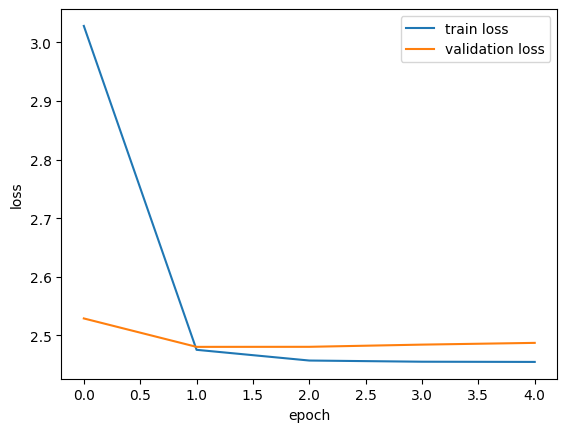

In [83]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()